In [1]:
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense,TimeDistributed,Embedding,Bidirectional
from keras.preprocessing.text import Tokenizer
from string import digits
import nltk
import re
import string
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
lines = pd.read_csv('hindi_english_parallel.csv')
lines.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,A list of plugins that are disabled by default


In [3]:
# Lowercase all characters
lines['english']=lines['english'].apply(lambda x: str(x))
lines['hindi']=lines['hindi'].apply(lambda x: str(x))
lines['english']=lines['english'].apply(lambda x: x.lower())
lines['hindi']=lines['hindi'].apply(lambda x: x.lower())
# Remove quotes
lines['english']=lines['english'].apply(lambda x: re.sub("'", '', x))
lines['hindi']=lines['hindi'].apply(lambda x: re.sub("'", '', x))
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['english']=lines['english'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi']=lines['hindi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english']=lines['english'].apply(lambda x: x.translate(remove_digits))
lines['hindi']=lines['hindi'].apply(lambda x: x.translate(remove_digits))
lines['hindi'] = lines['hindi'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['english']=lines['english'].apply(lambda x: x.strip())
lines['hindi']=lines['hindi'].apply(lambda x: x.strip())
lines['english']=lines['english'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi']=lines['hindi'].apply(lambda x: re.sub(" +", " ", x))
remove_digits = str.maketrans('', '', digits)

lines['hindi'] = lines['hindi'].apply(lambda x : 'START_ '+ x + ' _END')

In [4]:
lines = lines[:30000]
lines.head()

,hindi,english
0,START_ अपने अनुप्रयोग को पहुंचनीयता व्यायाम का...,give your application an accessibility workout
1,START_ एक्सेर्साइसर पहुंचनीयता अन्वेषक _END,accerciser accessibility explorer
2,START_ निचले पटल के लिए डिफोल्ट प्लगइन खाका _END,the default plugin layout for the bottom panel
3,START_ ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका _END,the default plugin layout for the top panel
4,START_ उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप...,a list of plugins that are disabled by default


In [5]:
all_eng_words=set()
for eng in lines['english']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in lines['hindi']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

([<matplotlib.patches.Wedge at 0x2d0b14310>,
 [Text(0.2105513728320813, 1.0796611132195721, 'English vocabulary'),
  Text(-0.21055137283208192, -1.0796611132195721, 'Hindi vocabulary')])

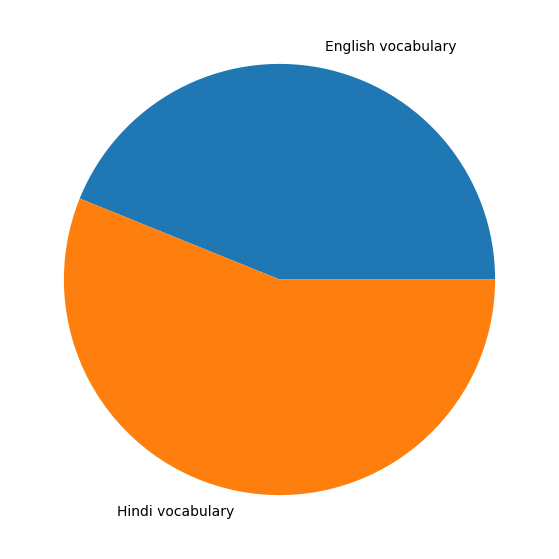

In [6]:
labels = 'English vocabulary', 'Hindi vocabulary'
data = [len(all_eng_words), len(all_hindi_words)]
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = labels)


In [11]:

data = {
    "DATASET":"IIT Bombay English-Hindi Translation Dataset",
  "Sentence Pairs(Utilized)" : [len(lines)],
  "Unique words (ENGLISH)": [len(all_eng_words)],
  "Unique words (HINDI)": [len(all_hindi_words)]
}

df = pd.DataFrame(data)
df 

,DATASET,Sentence Pairs(Utilized),Unique words (ENGLISH),Unique words (HINDI)
0,IIT Bombay English-Hindi Translation Dataset,30000,2687,3438


In [15]:
lines.head()

,hindi,english
0,START_ अपने अनुप्रयोग को पहुंचनीयता व्यायाम का...,give your application an accessibility workout
1,START_ एक्सेर्साइसर पहुंचनीयता अन्वेषक _END,accerciser accessibility explorer
2,START_ निचले पटल के लिए डिफोल्ट प्लगइन खाका _END,the default plugin layout for the bottom panel
3,START_ ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका _END,the default plugin layout for the top panel
4,START_ उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप...,a list of plugins that are disabled by default


In [16]:
lines['length_eng']=lines['english'].apply(lambda x:len(x.split(" ")))
lines['length_hin']=lines['hindi'].apply(lambda x:len(x.split(" ")))

In [17]:
lines[lines['length_eng']>30].shape
lines=lines[lines['length_eng']<=20]
lines=lines[lines['length_hin']<=20]

In [18]:
max_length_src=max(lines['length_hin'])
max_length_tar=max(lines['length_eng'])

In [19]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(2687, 3438)

In [20]:
num_decoder_tokens += 1

In [21]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [22]:
next(iter((input_token_index.items())) )

('a', 1)

In [23]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [24]:
next(iter((reverse_input_char_index.items())) )

(1, 'a')

In [25]:
lines.head()

,hindi,english,length_eng,length_hin
0,START_ अपने अनुप्रयोग को पहुंचनीयता व्यायाम का...,give your application an accessibility workout,6,10
1,START_ एक्सेर्साइसर पहुंचनीयता अन्वेषक _END,accerciser accessibility explorer,3,5
2,START_ निचले पटल के लिए डिफोल्ट प्लगइन खाका _END,the default plugin layout for the bottom panel,8,9
3,START_ ऊपरी पटल के लिए डिफोल्ट प्लगइन खाका _END,the default plugin layout for the top panel,8,9
4,START_ उन प्लगइनों की सूची जिन्हें डिफोल्ट रूप...,a list of plugins that are disabled by default,9,14


In [29]:
from sklearn.model_selection import train_test_split
X, y = lines['english'], lines['hindi']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((23712,), (5928,))

In [33]:
data = {
    "DATA SECTION":["Testing","Training"],
  "SENTENCE PAIRS" :[X_train.size,X_test.size],
}

df = pd.DataFrame(data)
df 

,DATA SECTION,SENTENCE PAIRS
0,Testing,23712
1,Training,5928


In [35]:
encoder_input_data = np.zeros((2, max_length_src),dtype='float32')
decoder_input_data = np.zeros((2, max_length_tar),dtype='float32')
decoder_target_data = np.zeros((2, max_length_tar, num_decoder_tokens),dtype='float32')

In [36]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] 
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word]
                    if t>0:
                        
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [37]:
latent_dim = 300
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens+1, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens+1, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Metal device set to: Apple M1


2022-12-13 19:27:41.248779: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-13 19:27:41.249414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [39]:
model.summary()
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 64
epochs = 20

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    806400      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    1032000     ['input_2[0][0]']                
                                                                                              

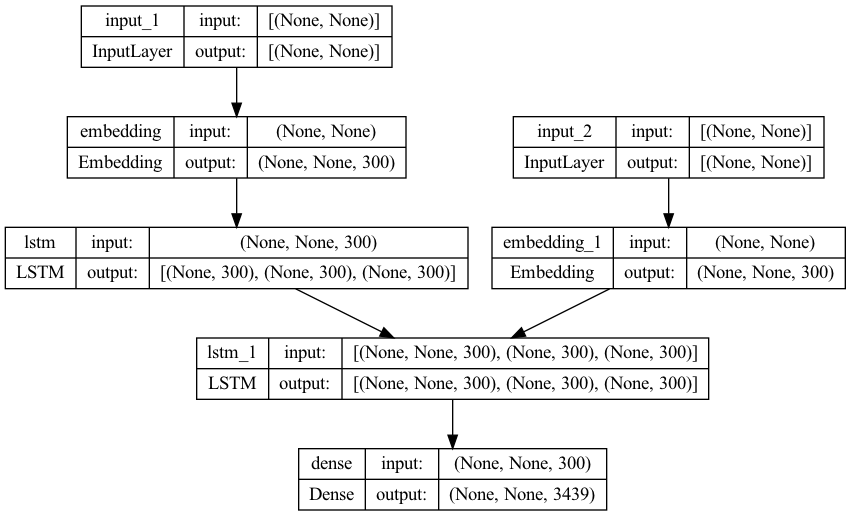

In [40]:
keras.utils.plot_model(model,show_shapes=True)

In [41]:
model.save('eng-to-hindi.h5')

In [42]:
a, b = next(generate_batch())

In [43]:
X_train[4]

'a list of plugins that are disabled by default'

In [44]:
h = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples/batch_size,
                    epochs=20,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples/batch_size)

Epoch 1/20


2022-12-13 19:27:47.548126: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-13 19:27:49.254172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-13 19:27:49.643445: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2022-12-13 19:27:49.646906: I tensorflow/core/grappler/optimizers/custom_grap

371/370 [==============================] - ETA: 0s - loss: 1.1106 - accuracy: 0.2499

2022-12-13 19:28:50.521606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-13 19:28:50.710610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-13 19:28:50.828434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


370/370 [==============================] - 67s 174ms/step - loss: 1.1106 - accuracy: 0.2499 - val_loss: 0.9640 - val_accuracy: 0.2952
Epoch 2/20
370/370 [==============================] - 60s 163ms/step - loss: 0.8991 - accuracy: 0.3261 - val_loss: 0.8325 - val_accuracy: 0.3549
Epoch 3/20
370/370 [==============================] - 60s 162ms/step - loss: 0.7775 - accuracy: 0.3756 - val_loss: 0.7401 - val_accuracy: 0.3955
Epoch 4/20
370/370 [==============================] - 63s 171ms/step - loss: 0.6741 - accuracy: 0.4309 - val_loss: 0.6407 - val_accuracy: 0.4535
Epoch 5/20
370/370 [==============================] - 64s 173ms/step - loss: 0.5639 - accuracy: 0.5008 - val_loss: 0.5475 - val_accuracy: 0.5148
Epoch 6/20
370/370 [==============================] - 61s 165ms/step - loss: 0.4690 - accuracy: 0.5676 - val_loss: 0.4707 - val_accuracy: 0.5782
Epoch 7/20
370/370 [==============================] - 59s 159ms/step - loss: 0.3950 - accuracy: 0.6255 - val_loss: 0.4154 - val_accuracy: 0.6

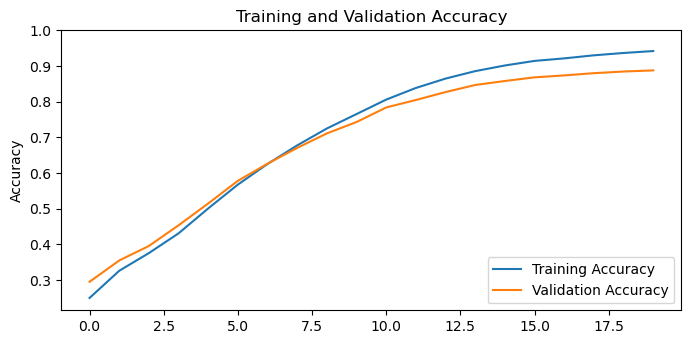

In [45]:
acc = h.history['accuracy']
val_acc = h.history['val_accuracy']

loss = h.history['loss']
val_loss = h.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


plt.show()

Text(0.5, 1.0, 'Training and Validation Loss')

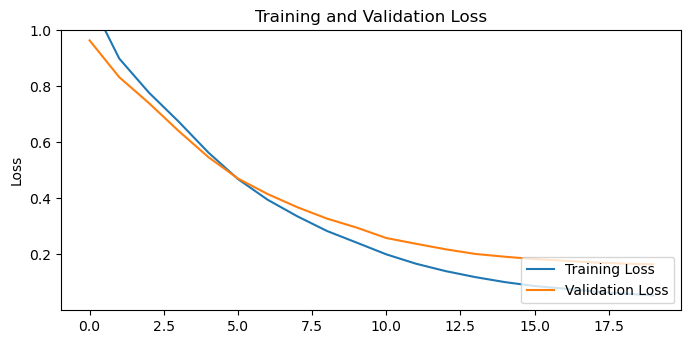

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')

In [47]:
d = {'Epochs':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 'Accuracy': acc, 'Loss':loss}
df = pd.DataFrame(data =d)
df.reset_index(drop=True, inplace=True)
df

,Epochs,Accuracy,Loss
0,1,0.251309,1.108800
1,2,0.326054,0.896438
2,3,0.377196,0.775492
3,4,0.438487,0.664204
4,5,0.504374,0.559180
5,6,0.564186,0.475431
6,7,0.606618,0.420596
7,8,0.662060,0.349234
8,9,0.706801,0.296290
9,10,0.748010,0.251136


In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [38]:
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) 


decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [39]:
def decode_sequence(input_seq):
  
    states_value = encoder_model.predict(input_seq)
  
    target_seq = np.zeros((1,1))
 
    target_seq[0, 0] = target_token_index['START_']

   
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

       
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

      
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True


        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index


        states_value = [h, c]

    return decoded_sentence

In [40]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 454ms/step


2022-11-23 11:33:57.380481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-23 11:33:57.463513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 451ms/step


2022-11-23 11:33:57.850309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-23 11:33:57.942586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 20ms/step
Input English sentence: merged s
Actual Hindi Translation:  मिलाया से 
Predicted Hindi Translation:  मिलाया से 


In [42]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 13ms/step
Input English sentence: move a onto the jack of diamonds
Actual Hindi Translation:  a को एक ईंट का गुलाम पर ले जाएँ 
Predicted Hindi Translation:  a को एक ईंट का इक्का पर ले जाएँ 


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score